# Data Engineering Take-Home Assignment: Nature Conservation & Geospatial Data

## Context
Assume you have been hired as a Data Engineer for an organization focused on nature conservation. The organization is working on a project to monitor and protect natural habitats using satellite data, wildlife sensor data, and geospatial information. Your task is to design and implement a data pipeline that ingests, processes, and analyzes this data to help identify areas needing immediate conservation attention as well as build a model that provides helpful insights related our organization's interests.

## Objective 

Your goal in this assessment is to showcase your curiousity and creativity to design rigorous models and derive interesting insights.  

You'll be given two tasks.

The first is a design task, in which we expect you to diagram and describe how you'd set up a process to injest this data from a live streamed source, assuming you are also paying monitoring services to supply this data from scratch. Think about how you might transform and store the data efficiently for querying and analysis and feed it into your model. 

The second task will require you devise interesting questions from preliminary explorations of a subset of migration data, found alongside this notebook, and construct a rigorous model to answer them. Please demonstrate all of your process using this notebook, and most importantly your outputs. 




## Tasks

### 1) Design - Data Ingestion & Storage:
- **Ingestion**: Design and implement a solution to ingest data from three different sources: GeoJSON, CSV, and JSON.
- **Automation**: Ensure the pipeline can handle regular data updates (e.g., daily or hourly).
- **Storage**: Choose appropriate storage solutions for each dataset (e.g., relational database, NoSQL, cloud storage, or data lake). Provide justification for your choices.

### 2) Data Transformation & Analysis:
- **Data Parsing & Cleaning**: 
  - Parse and clean the wildlife tracking data (CSV) and geospatial data (GeoJSON) to ensure consistency.
  - Ensure the data is ready for analysis by standardizing formats, removing errors, and handling missing values.

- **Exploratory Data Analysis**:
  - Investigate the data to understand key characteristics, distributions, and trends.

- **Behavioral Analysis**:
  - Identify more complex animal behaviors:
    - Determine when animals cross the boundaries of protected areas.
    - Analyze potential factors contributing to these crossings (e.g., time, weather, or environmental changes).
    - Calculate the total number of animal entries and exits from protected areas over time.

- **Advanced Insights**:
  - Identify migration paths or clustering patterns.
  - Build a predictive model to anticipate future animal movements or identify risk zones for endangered species.

### 3) Optional Bonus - Visualization/Reporting:
- Provide interactive visualizations to demonstrate your analysis, ideally within this notebook.

### Here are data sources you can use to build your analysis. 

- https://storage.googleapis.com/data-science-assessment/animal_events.csv
- https://storage.googleapis.com/data-science-assessment/animals.csv
- https://storage.googleapis.com/data-science-assessment/protected_areas.json
- https://storage.googleapis.com/data-science-assessment/satellites.json

## Deliverables
#### Design component:
- A clear description and diagrams for the architecture and tools you might used, including any cloud services, databases, or libraries (if applicable). During the discussion we'll go over different scenarios. 

#### Implementation:
- Code for the data pipeline that includes:
  - Data ingestion scripts or setup.
  - Transformation and processing logic.
  - Queries or outputs showcasing the results.
- (Optional) a visualization of the results.

## Data
### 1. **Animal Events - CSV** [Download link](https://storage.googleapis.com/data-science-assessment/animal_events.csv)

- Contains data on animal movement events with details like location and speed.
- **Key Columns**: `event_id`, `animal_id`, `timestamp`, `latitude`, `longitude`, `speed`.

---

### 2. **Animals - CSV** [Download link](https://storage.googleapis.com/data-science-assessment/animals.csv)

- Metadata about tracked animals, including species and conservation status.
- **Key Columns**: `animal_id`, `species`, `endangered`, `animal_type`, `preferred_landcover`.

---

### 3. **Protected Areas - GeoJSON** [Download link](https://storage.googleapis.com/data-science-assessment/protected_areas.json)

- Geospatial data representing protected areas with boundaries and metadata.
- **Key Fields**: `name`, `category`, `protected_area_id`, `geometry`.

---

### 4. **Satellite Metadata - JSON** [Download link](https://storage.googleapis.com/data-science-assessment/satellites.json)

- Metadata from satellite imagery, covering factors like cloud cover and resolution.
- **Key Fields**: `satellite_id`, `start_time`, `last_time`, `frequency`, `bounding_box`, `cloud_cover_percentage`, `resolution`.

---

## Evaluation Criteria

- **Data Engineering Skills**: How well the pipeline handles ingestion, transformation, and storage.
- **Geospatial Data Handling**: Ability to process geospatial data and perform spatial operations (e.g., joins, intersections).
- **Scalability & Efficiency**: The pipeline’s ability to handle larger datasets or more frequent updates.
- **Code Quality**: Structure, readability, and use of best practices.
- **Documentation**: Clear explanations of your approach and any assumptions made.
- **Bonus (Visualization/Reporting)**: Extra points for insightful data visualization or reporting.

### 1) Design - Data Ingestion & Storage:
This task is similar to a project I worked on before, Anomaly Detection on user file activity. It was a solution built to to discover anomalies on mix of structured and semi-structured data on a daily basis, and I can apply a lot of what I learnt there here as well.

We will be sticking to AWS for most services to leverage the native integration and support provided for linked services, and also becase its cloud services are still the most used and well documented in the industry.

The most important takeway when it comes to both Data and ML engineering that I have learnt is to always start simple (K-I-S-S), then make optimizations as we consider potential challenges.


**Ingestion**: Design and implement a solution to ingest data from three different sources: GeoJSON, CSV, and JSON.
* Assuming the monitoring services (satellites, sensors) are not already putting data into stream for us (AWS Data Exchange), I would set up a HTTP server using Flask, Docker and uwsgi (potentially Kubernetes for scaling) to periodically poll the source API and put to stream.
* We can use AWS Kinesis for high thoroughput streaming. Kinesis is a fault tolerant and reliable solution for high volume realtime ingestion, and it's much easier to setup compared to competitors like Kafka as it is fully managed by AWS, allowing us to focus on data analysis. We can also easily monitor the pipeline on the AWS console and setup alerts using CloudWatch.
* We start with 3 streams, one for each data source, with a variable number of shards as per thoroughput. As we have relatively large intervals between data updates, that leads to a large amount of data being sent at once and would therefore need to be split into chunks and sent in microbatches.
* At scale, we would want to consider Apache Kafka and NiFi as, after the initial resources to setup, it is cheaper at large data volumes and for longer retention.

**Automation**: Ensure the pipeline can handle regular data updates (e.g., daily or hourly).
* Cron for scheduling. Apache Airflow is an option as well as it offers more customization (retries, inbuilt monitoring) and scaling with a large number of jobs, but starting with cron is as simple as writing a single line on a crontab to run a job at at specific interval.
* For data transformation, we will use AWS EMR. This is another service provided by AWS to run Spark/Hadoop on EMR, distributed among underlying EC2 instances. AWS Lambda is an option as well, but it has a runtime ceiling of 15 miniutes and EMR is better for parallel computing of Big Data.
* Since we are not updating data constantly but at relatively large intervals, we will not keep the EMR instance persistent, but rather trigger EMR Serverless jobs using Cron and awscli that will process each hourly/daily batch then terminate once it encounters an end-of-stream marker.
* Scaling is taken care of by AWS, and it is easy to view the health and performance of jobs on the dashboard and adjust the aggressiveness of the scaling as needed.

**Storage**: Choose appropriate storage solutions for each dataset (e.g., relational database, NoSQL, cloud storage, or data lake). Provide justification for your choices.
* CSV - We will use AWS Redshift, the in-house version of Postgres which works well with batch copying of large amounts of animal events and allows for complex queries on time series data with predefined schemas. The csv data is also mostly static.
* JSON - We will store the JSON data in a NoSQL database such as MongoDB. I would have liked to use a data lake such as S3 instead as it is very cheap to store raw data but since we have to perform updates on satellite coordinates we must use a database instead. 
* GeoJSON - We handle the protected areas GeoJSON data the same way as the JSON data instead of S3 for simplicity and potential geospatial querying functionality.
* DocumentDB is the AWS solution to MongoDB. It reduces operational overhead and handles scaling. NoSQL is better for storing JSON as we do not need a predefined schema like in Postgres and can index keys, though to be fair SQL and NoSQL have reached feature parity in most scenarios in this day and age (https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0262-8). However, DocumentDB does not offer nearly as many advanced features as MongoDB, particularly when querying geospatial data, so we must consider whether we will need that functionality down the road.

In [1]:
import base64
from IPython.display import Image, display

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.urlsafe_b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

# Define the Mermaid chart
mermaid_chart = """
flowchart TD
%%{init: {'look': 'handDrawn'}}%%
    A[Monitoring Services] -->|Data| B[HTTP Server]
    B -->|Flask, Docker, uWSGI| C[AWS Kinesis]
    C -->|Stream Data| D[AWS EMR Serverless PySpark]
    E[Cron] -->|Schedule| D
    D -->|ETL| F{Data Type}
    F -->|CSV| G[AWS Redshift]
    F -->|JSON| H[DocumentDB]
    F -->|GeoJSON| H
    I[CloudWatch/Console] -->|Monitor & Alert| C
"""

mm(mermaid_chart)


```python
import json
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.streaming.kinesis import KinesisUtils, InitialPositionInStream


def send_logs_to_redshift(rdd):
    rdd.copy_logs_to_redshift(schema_type='csv_logs')
    
def main():
    app_name = "csv-log-processor-"
    spark_context = SparkContext(appName=app_name)
    streaming_context = StreamingContext(spark_context, 240)
    kinesis_endpoint = "https://kinesis.{}.amazonaws.com".format('us-west-2')
    kinesis_stream_name = "csv-raw-logs-{}"
    kinesis_streams = [KinesisUtils.createStream(streaming_context, app_name, kinesis_stream_name,
                                               kinesis_endpoint, InitialPositionInStream.TRIM_HORIZON,
                                               240) for _ in range(4)]
    kinesis_stream = streaming_context.union(*kinesis_streams)
    split_logs = kinesis_stream.flatMap(lambda log: str(log).strip('\n').split('\n'))
    parsed = split_logs.map(lambda log: json.loads(str(log)))
    formatted = parsed.mapPartitions(partial(deduplicate_by_id, field='id'))
    formatted.cache()

    formatted.foreachRDD(send_logs_to_redshift)
    ```

Here is the basic template of a spark job to process csv events, lifted from a previous project

### 2) Data Transformation & Analysis:
- **Data Parsing & Cleaning**: 
  - Parse and clean the wildlife tracking data (CSV) and geospatial data (GeoJSON) to ensure consistency.
  - Ensure the data is ready for analysis by standardizing formats, removing errors, and handling missing values.

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import TimestampedGeoJson
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import DBSCAN
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

In [3]:
animals = pd.read_csv("data/animals.csv")
animals

,animal_id,common_name,scientific_name,redlist_cat,megafauna
0,A001,Wolf,Canis lupus,Least Concern,no
1,A002,Bison,Bison bison,Vulnerable,yes
2,A003,Elk,Cervus canadensis,Least Concern,yes
3,A004,Sierra Nevada bighorn sheep,Ovis canadensis sierrae,Endangered,no
4,A005,Sierra Nevada red fox,Vulpes vulpes necator,Critically Endangered,no
5,A006,Bobcat,Lynx rufus,Least Concern,yes
6,A007,Mule deer,Odocoileus hemionus,Least Concern,yes
7,A008,Desert bighorn sheep,Ovis canadensis nelsoni,Near Threatened,yes
8,A009,Gray fox,Urocyon cinereoargenteus,Least Concern,yes


In [4]:
animals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   animal_id        9 non-null      object
 1   common_name      9 non-null      object
 2   scientific_name  9 non-null      object
 3   redlist_cat      9 non-null      object
 4   megafauna        9 non-null      object
dtypes: object(5)
memory usage: 488.0+ bytes


In [5]:
animals['megafauna'] = animals['megafauna'].map({'yes': True, 'no': False})

In [6]:
animal_events = pd.read_csv("data/animal_events.csv", parse_dates=["timestamp"])
animal_events.head()

,animal_id,timestamp,latitude,longitude
0,A001,2024-09-01 12:00:00,45.2284,-110.7622
1,A002,2024-09-01 12:00:00,44.5760,-110.6763
2,A003,2024-09-01 12:00:00,44.4232,-111.1061
3,A004,2024-09-01 12:00:00,37.9058,-119.7857
4,A005,2024-09-01 12:00:00,37.7896,-119.6426


In [7]:
animal_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   animal_id  27 non-null     object        
 1   timestamp  27 non-null     datetime64[ns]
 2   latitude   27 non-null     float64       
 3   longitude  27 non-null     float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 992.0+ bytes


In [8]:
# Make sure all animal ids match
set(animal_events['animal_id']) == set(animals['animal_id'])

True

In [9]:
# Convert animal events to a GeoDataFrame based on latitude and longitude
animal_events['geometry'] = animal_events.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
animal_events = gpd.GeoDataFrame(animal_events, geometry='geometry', crs="EPSG:4326")
animal_events.head()

,animal_id,timestamp,latitude,longitude,geometry
0,A001,2024-09-01 12:00:00,45.2284,-110.7622,POINT (-110.7622 45.2284)
1,A002,2024-09-01 12:00:00,44.5760,-110.6763,POINT (-110.6763 44.576)
2,A003,2024-09-01 12:00:00,44.4232,-111.1061,POINT (-111.1061 44.4232)
3,A004,2024-09-01 12:00:00,37.9058,-119.7857,POINT (-119.7857 37.9058)
4,A005,2024-09-01 12:00:00,37.7896,-119.6426,POINT (-119.6426 37.7896)


In [10]:
protected_areas = gpd.read_file("data/protected_areas.json", crs="EPSG:4326")
protected_areas

/Users/krish.ghiya/Library/Python/3.9/lib/python/site-packages/pyogrio/raw.py:196: RuntimeWarning: driver GeoJSON does not support open option CRS
  return ogr_read(


,name,category,protected_area_id,geometry
0,Yellowstone National Park,National Park,PA001,"POLYGON ((-110.839 44.4488, -110.7052 44.599, ..."
1,Yosemite National Park,National Park,PA002,"POLYGON ((-119.655 37.7244, -119.5964 37.6962,..."
2,Grand Canyon National Park,National Park,PA003,"POLYGON ((-112.1861 36.1336, -112.2156 36.2331..."


In [11]:
protected_areas.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   name               3 non-null      object  
 1   category           3 non-null      object  
 2   protected_area_id  3 non-null      object  
 3   geometry           3 non-null      geometry
dtypes: geometry(1), object(3)
memory usage: 224.0+ bytes


In [12]:
satellites = pd.read_json("data/satellites.json")
satellites

,satellite_id,start_time,last_time,frequency,bounding_box,cloud_cover_percentage,resolution
0,SAT001,2018-09-01 12:00:00+00:00,2024-09-10 12:00:00+00:00,daily,"{'xmin': -112.939131, 'ymin': 42.596356, 'xmax...",12.5,10m
1,SAT002,2004-09-01 12:00:00+00:00,2024-09-06 12:00:00+00:00,bi-weekly,"{'xmin': -180, 'ymin': -90, 'xmax': 180, 'ymax...",10.0,100m
2,SAT003,2022-09-01 12:00:00+00:00,2024-09-10 12:00:00+00:00,hourly,"{'xmin': -124.178099, 'ymin': 30.738207, 'xmax...",10.0,20m


While there are no missing values, there are different ways we could have handled missing values depending on the column and dataset:
- Mode of subset
- Drop
- Median

**Exploratory Data Analysis**:
  - Investigate the data to understand key characteristics, distributions, and trends.

- **Behavioral Analysis**:
  - Identify more complex animal behaviors:
    - Determine when animals cross the boundaries of protected areas.
    - Analyze potential factors contributing to these crossings (e.g., time, weather, or environmental changes).
    - Calculate the total number of animal entries and exits from protected areas over time.

We plot the animal movements within and outside the protection areas, and overlay terrain as well so as to discover potential reasons for exiting safe boundaries.

In [13]:
# Merge animal events with animal metadata
gdf_events = animal_events.merge(animals, on='animal_id')

# Calculate distances for each animal in meters
gdf_events['prev_point'] = gdf_events.groupby('animal_id')['geometry'].shift()
gdf_events['distance'] = gdf_events.apply(
    lambda row: row.geometry.distance(row.prev_point) * 1000 if row.prev_point else 0,
    axis=1
)

# Generate distinct colors for animals using a colormap
animal_colors = plt.get_cmap('tab20')
animal_color_map = {
    row['common_name']: f'#{int(255 * c[0]):02x}{int(255 * c[1]):02x}{int(255 * c[2]):02x}'
    for i, row in animals.iterrows()
    for c in [animal_colors(i)[:3]]
}

# Helper function to add a legend
def add_legend(map_obj, title, data, position_style):
    html = f'<div style="position:fixed; {position_style}; z-index:9999; background-color:white; padding:10px; border:2px solid gray;"><h4>{title}</h4>'
    for item in data:
        html += f'<i style="background:{item["color"]}; height:10px; width:10px; float:left; margin-right:5px;"></i>{item["name"]}<br>'
    html += '</div>'
    map_obj.get_root().html.add_child(folium.Element(html))

# Define a function to create PolyLine with dotted pattern
def add_movement_lines(map_obj, grouped_data, color_map):
    for animal_id, group in grouped_data:
        points = [(point.y, point.x) for point in group.geometry]
        polyline = folium.PolyLine(
            points,
            color=color_map[group.iloc[0]['common_name']],
            weight=2,
            opacity=0.6,
            dashArray='5, 10'  # 'dashArray' option makes the line dotted
        )
        map_obj.add_child(polyline)

# Group the data by 'animal_id'
grouped_events = gdf_events.groupby('animal_id')

# Calculate the center of the map
bounds = gdf_events.total_bounds
center_lat = (bounds[1] + bounds[3]) / 2
center_lon = (bounds[0] + bounds[2]) / 2

# Initialize the Folium map
m = folium.Map(location=[center_lat, center_lon], zoom_start=5)
m.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])

# Add Esri basemap
folium.TileLayer('Esri.WorldImagery').add_to(m)

# Add protected areas as GeoJSON
for _, row in protected_areas.iterrows():
    popup_content = folium.Popup(row[0], parse_html=True)
    geojson = folium.GeoJson(row.geometry.__geo_interface__, 
                             style_function=lambda x: {
                                 'fillColor': 'green',
                                 'color': 'green',
                                 'fillOpacity': 0.2,
                                 'weight': 1
                             })
    geojson.add_child(popup_content)
    geojson.add_to(m)

# Add movement lines
add_movement_lines(m, grouped_events, animal_color_map)

# Prepare GeoJSON data for points
features = []
for idx, row in gdf_events.iterrows():
    popup_content = (
        f"<b>Name:</b> {row['common_name']}<br>"
        f"<b>Scientific Name:</b> {row['scientific_name']}<br>"
        f"<b>Concern Level:</b> {row['redlist_cat']}<br>"
        f"<b>Timestamp:</b> {row['timestamp']}<br>"
        f"<b>Distance:</b> {row['distance']:.2f} m"
    )
    
    feature = {
        "type": "Feature",
        "geometry": row.geometry.__geo_interface__,
        "properties": {
            "time": row['timestamp'].strftime('%Y-%m-%dT%H:%M:%S'),
            "style": {
                "color": animal_color_map[row['common_name']]
            },
            "icon": "circle",
            "iconstyle": {
                "fillColor": animal_color_map[row['common_name']],
                "fillOpacity": 0.6,
                "stroke": "true",
                "radius": 4
            },
            "popup": popup_content
        }
    }
    features.append(feature)

geojson_data = {
    "type": "FeatureCollection",
    "features": features
}

# Ensure popups are correctly handled in TimestampedGeoJson
timestamped_geojson = TimestampedGeoJson(
    geojson_data,
    period="PT1H",  # Set time interval here (e.g., 'P1D' for one day, 'PT1H' for one hour)
    add_last_point=True,
    auto_play=False,
    loop=False,
    max_speed=1,
    loop_button=True,
    date_options='YYYY-MM-DD HH:mm:ss',
    time_slider_drag_update=True
)

# Add the TimestampedGeoJson layer to the map
m.add_child(timestamped_geojson)

# Create legends
animal_legend_data = [
    {"name": row['common_name'], "color": animal_color_map[row['common_name']]} for _, row in animals.iterrows()
]

protected_area_data = [
    {"name": feature.name, "color": 'green'} for feature in protected_areas.itertuples()
]

# Position legends to avoid overlap.
add_legend(m, "Animals", animal_legend_data, position_style='bottomleft: 50px; bottom: 70px;')
add_legend(m, "Protected Areas", protected_area_data, position_style='bottomleft: 50px; bottom: 300px;')

# Add Layer Control
folium.LayerControl().add_to(m)

# Display map inline in Jupyter notebook
m

- We can track the movements of all the animals over time. We observe that the most endangered animals, the sierra nevada fox and sheep have correlating movements, with the fox perhaps chasing the scent of the sheep. Connections between predator and prey should be researched further.
- We also observe the influence of terrain, for example the mule deer in grand canyon leaves the protected zone to go to different woodland areas, perhaps foraging for food, so habitats of animals and scarcity of resources should be researched further
- We observe the bison, leaving the zone towards the end and heading out into the open, which perhaps explains why it is vulnerable

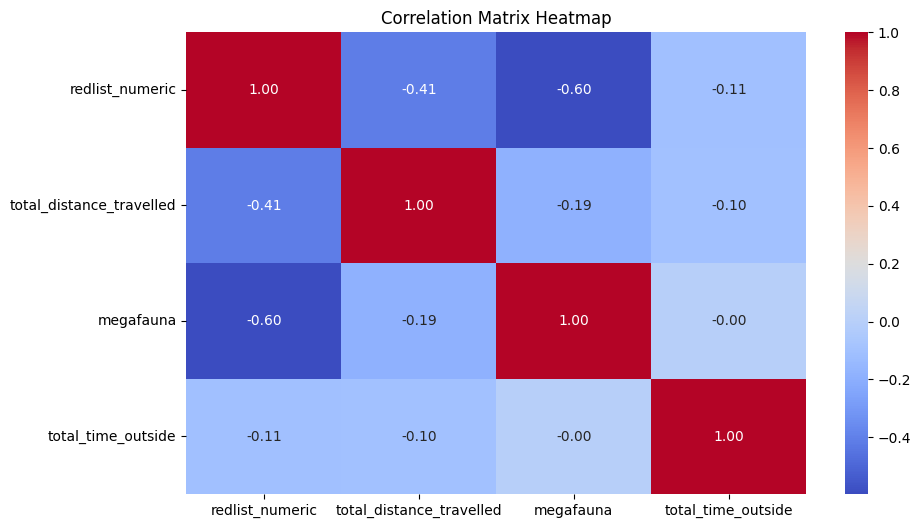

In [14]:
# Update these based on actual column names from inspection
location_x_column = 'longitude'  
location_y_column = 'latitude'   
timestamp_column = 'timestamp'

# Merge dataframes
merged_df = gdf_events.copy()

# Summing up distances per animal
distance_per_animal = merged_df.groupby('animal_id')['distance'].sum().reset_index()
distance_per_animal.rename(columns={'distance': 'total_distance_travelled'}, inplace=True)

# Merging with main dataframe
merged_df = merged_df.merge(distance_per_animal, on='animal_id', how='left')

# Convert timestamp to datetime
merged_df[timestamp_column] = pd.to_datetime(merged_df[timestamp_column])

# Function to calculate time out of protected area
def calculate_time_outside(df, protected_areas_gdf):
    df['out_of_area'] = False
    for idx, row in df.iterrows():
        point = gpd.GeoSeries(gpd.points_from_xy([row[location_x_column]], [row[location_y_column]]), crs=protected_areas_gdf.crs)
        contained = protected_areas_gdf.contains(point[0]).any()
        df.at[idx, 'out_of_area'] = not contained
    return df

merged_df = calculate_time_outside(merged_df, protected_areas)

# Calculating duration outside
merged_df['previous_timestamp'] = merged_df.groupby('animal_id')[timestamp_column].shift(1)
merged_df['time_diff'] = (merged_df[timestamp_column] - merged_df['previous_timestamp']).dt.total_seconds() / 3600.0
merged_df['time_outside'] = merged_df['time_diff'] * merged_df['out_of_area']

# Summing up time outside per animal
time_outside_per_animal = merged_df.groupby('animal_id')['time_outside'].sum().reset_index()
time_outside_per_animal.rename(columns={'time_outside': 'total_time_outside'}, inplace=True)

# Merging with main DataFrame
merged_df = merged_df.merge(time_outside_per_animal, on='animal_id', how='left')

# Mapping Red List categories to numerical values
redlist_mapping = {
    'Least Concern': 1,
    'Vulnerable': 2,        # -- > Seem interchangeable
    'Near Threatened': 3,   # -- ^
    'Endangered': 4,
    'Critically Endangered': 5
}

merged_df['redlist_numeric'] = merged_df['redlist_cat'].map(redlist_mapping)

# Selecting relevant features for correlation
correlation_columns = ['redlist_numeric', 'total_distance_travelled', 'megafauna', 'total_time_outside']
correlation_data = merged_df.drop_duplicates('animal_id')[correlation_columns]

# Computing the correlation matrix
correlation_matrix = correlation_data.corr()

# Plotting heatmap of the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

- Significant negative correlation with megafauna:
More endangered species are less likely to be megafauna.

- Moderate negative correlation with total distance travelled:
Higher Red List category values (more endangered species) tend to travel less distance.

- Negative correlation with total time outside protected areas:
More endangered species tend to spend less time outside protected areas.

- Slight negative correlation with megafauna:
Megafauna species tend to travel slightly shorter distances.

- Slight negative correlation with total time outside protected areas:
Animals that travel more distances seem to spend slightly less time outside protected areas.

- Being classified as megafauna does not significantly affect the time spent outside protected areas.

Practical Insights
- <b>Conservation Efforts</b>:
Given that more endangered species travel less and spend less time outside protected areas, conservation efforts might need to focus more on creating better habitats within protected areas to minimize their need to move outside for resources.

- <b>Movement Patterns</b>:
The fact that megafauna travel slightly less distance suggests that these large animals might have larger home ranges or require specific habitats that limit their movement.

- <b>Policy Making</b>:
By understanding these correlations, policymakers can better design protected areas considering the movement patterns of endangered species and megafauna, potentially reducing human-wildlife conflict and increasing habitat safety.

- <b>Further Research</b>:
The weak correlations suggest that there may be other factors influencing these behaviors that should be investigated further. For instance, factors like availability of food sources, seasonal migrations, and human disturbances could provide additional insights.



### Advanced Insights:
  - **Risk Zone Identification:**
   - **Objective:** Identify risk zones where endangered species might be prone to danger or leave protected areas.
   - **Approach options:**
     - **Cluster Analysis (start simple):** Use clustering techniques (e.g., DBSCAN) to identify high-risk zones based on historical movement patterns.
     - **Anomaly Detection:** Implement anomaly detection models to spot unusual movements that could signify risk.
     - **Geospatial Analysis:** Combine animal movement data with environmental factors (e.g., weather, terrain) to predict risk zones using geospatial analytics.

Best parameters for Yellowstone: eps=0.182, min_samples=3, clusters=1
Best parameters for Yosemite: eps=0.082, min_samples=3, clusters=2
Best parameters for Grand Canyon: eps=0.28200000000000003, min_samples=3, clusters=1


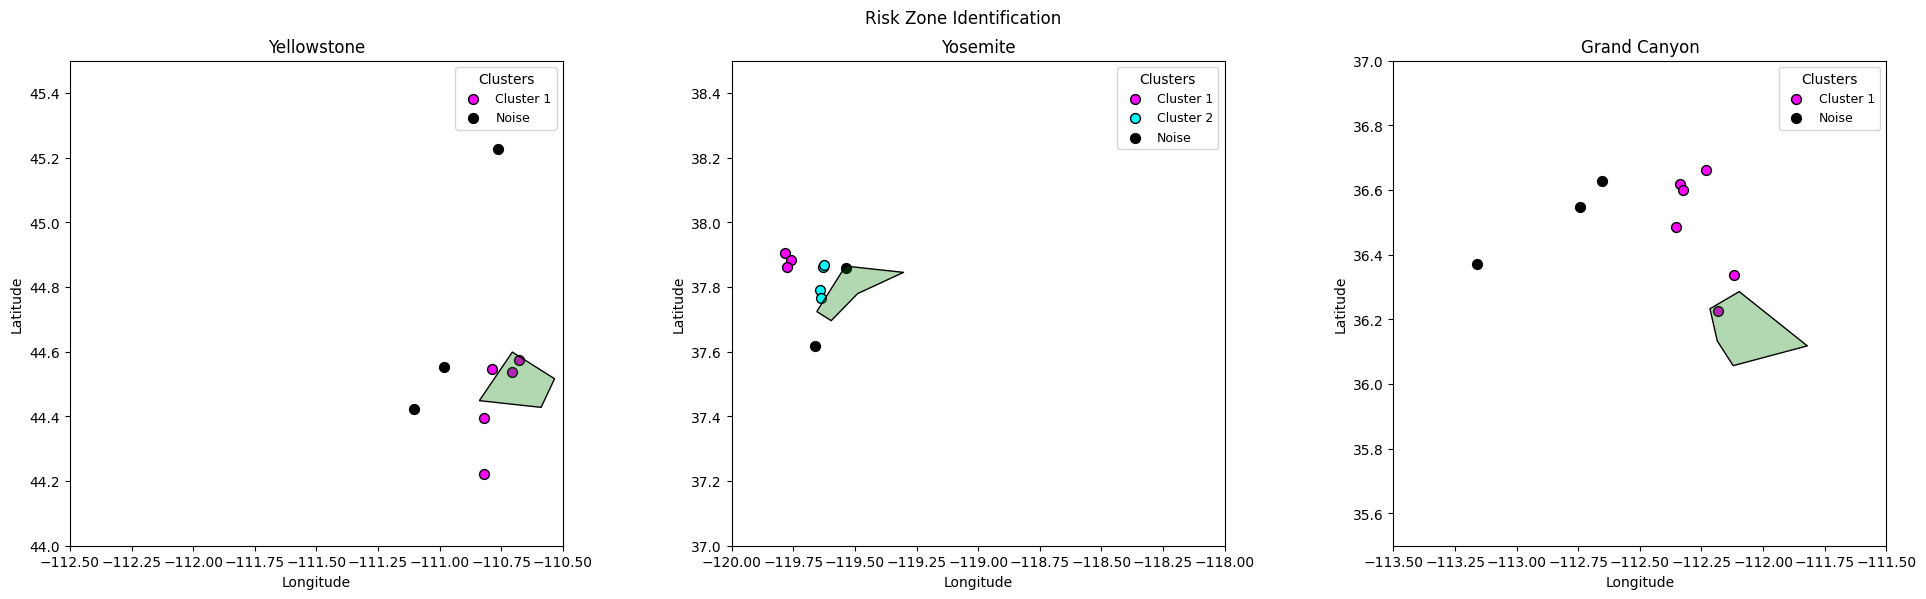

In [15]:
# Define the coordinate ranges for each region
region_ranges = [
    {'xlim': (-112.5, -110.5), 'ylim': (44.0, 45.5), 'title': 'Yellowstone'},
    {'xlim': (-120.0, -118.0), 'ylim': (37.0, 38.5), 'title': 'Yosemite'},
    {'xlim': (-113.5, -111.5), 'ylim': (35.5, 37.0), 'title': 'Grand Canyon'}
]

# Hyperparameter grid for DBSCAN
epsilon_values = np.arange(0.002, 3, 0.01)
min_samples_list = range(3, 15)

def dbscan_grid_search(coordinates):
    optimal_model = None
    max_clusters = -1  
    optimal_epsilon = None
    optimal_min_samples = None
    
    for epsilon in epsilon_values:
        for min_samples in min_samples_list:
            db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(coordinates)
            labels = db.labels_
            
            num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            num_noise = list(labels).count(-1)
            
            if num_clusters > max_clusters and num_noise < len(coordinates) * 0.5:
                optimal_model = db
                max_clusters = num_clusters
                optimal_epsilon = epsilon
                optimal_min_samples = min_samples
    
    return optimal_model, optimal_epsilon, optimal_min_samples, max_clusters

def visualize_clusters(ax, data, colors, noise_color, title, xlim, ylim):
    labels = data['cluster']
    for cluster_label in set(labels):
        color = noise_color if cluster_label == -1 else colors(int(cluster_label))
        label = 'Noise' if cluster_label == -1 else f'Cluster {int(cluster_label) + 1}'
        
        ax.scatter(
            data.loc[labels == cluster_label, 'longitude'],
            data.loc[labels == cluster_label, 'latitude'],
            color=color, label=label, s=50, edgecolor='k'
        )
    
    # Fill protected areas with see-through color
    protected_areas.boundary.plot(ax=ax, color='black', linewidth=1)
    protected_areas.plot(ax=ax, color='green', alpha=0.3, edgecolor='none')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=9, title='Clusters')

# Load data (assuming animal_events and protected_areas are already loaded)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# New colors for clusters (max of 10 clusters) and noise
new_cluster_colors = ListedColormap(['magenta', 'cyan', 'yellow', 'lime', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray'])
noise_color = 'black'

for i, region in enumerate(region_ranges):
    ax = axes[i]
    in_region = (
        (animal_events['longitude'] >= region['xlim'][0]) &
        (animal_events['longitude'] <= region['xlim'][1]) &
        (animal_events['latitude'] >= region['ylim'][0]) &
        (animal_events['latitude'] <= region['ylim'][1])
    )

    region_coords = animal_events.loc[in_region, ['longitude', 'latitude']].to_numpy()

    if len(region_coords) > 0:
        optimal_model, optimal_epsilon, optimal_min_samples, max_clusters = dbscan_grid_search(region_coords)

        if optimal_model is not None:
            animal_events.loc[in_region, 'cluster'] = optimal_model.labels_
            print(f"Best parameters for {region['title']}: eps={optimal_epsilon}, min_samples={optimal_min_samples}, clusters={max_clusters}")
        else:
            animal_events.loc[in_region, 'cluster'] = -1
        
        visualize_clusters(ax, animal_events.loc[in_region], new_cluster_colors, noise_color, region['title'], region['xlim'], region['ylim'])
    else:
        print(f"No coordinates found for {region['title']}")

plt.suptitle('Risk Zone Identification')
plt.tight_layout()
plt.show()


In [16]:
animal_events['hour'] = animal_events['timestamp'].apply(lambda x: x.hour)
animal_events.groupby(['hour', 'cluster']).size().unstack(fill_value=0)

cluster,-1.0,0.0,1.0
hour,,,
12,3,5,1
13,0,7,2
14,5,2,1


We make an effort to identiy risk zones, which is difficult due to the extremely small size of the dataset, but we can see that most clusters tend to be close to the edges of the protected area, where the animals usually begin, and we can then keep closer watch on movements of animals in the cluster area as they tend to signal likelihood of the animals ranging further away

### Build a predictive model to anticipate future animal movements
- **Migration Path Prediction:**
   - **Objective:** Predict future migration paths of animals based on historical data and predict when an animal is likely to leave the boundary of a protected area.
   - **Approach options:**
     - **Time Series Models:** Utilize time series forecasting models like ARIMA or Prophet to predict future locations.
     - **Recurrent Neural Networks (RNNs):** Use LSTM or GRU networks for sequence prediction.
     - **Spatial-Temporal Models:** Combine spatial and temporal features using models like ST-GCN (Spatial-Temporal Graph Convolutional Networks).
     - **Classification Models:** Train classification models (e.g., Logistic Regression, Random Forest, XGBoost) to predict boundary-crossing events.
     - **Markov Chains:** Use Markov Chain models to predict state transitions (inside/outside protected areas).

In [17]:
# Additional imp# Create features for time series prediction
animal_events['hour'] = animal_events['timestamp'].dt.hour
animal_events['day_of_week'] = animal_events['timestamp'].dt.dayofweek
animal_events = animal_events.merge(animals, on='animal_id')

# Prepare data for LSTM model
def create_sequence(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length][:2])  # Predict only latitude and longitude
    return np.array(X), np.array(y)

seq_length = 3  # Using past 3 events to predict next
features = ['latitude', 'longitude', 'hour', 'day_of_week']
X, y = create_sequence(animal_events[features].values, seq_length)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, X.shape[2])))
model.add(Dense(2))  # Output layer for latitude and longitude
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100


/Users/krish.ghiya/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step - loss: 6706.9185 - val_loss: 6589.0166
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6577.1133 - val_loss: 6459.4438
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6449.9702 - val_loss: 6332.4038
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6325.2544 - val_loss: 6206.0151
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6201.0591 - val_loss: 6078.9170
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6075.5322 - val_loss: 5950.5088
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5948.6958 - val_loss: 5819.9253
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5819.6655 - val_loss: 5686.7007
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5687.8628 - val_loss: 5555.2500
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5557.1475 - val_loss: 5422.9424
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5424.8765 - val_loss: 5289.2441
Epoch 12/100
1/1 ━━

In [18]:
# Extract timestamps for generating future predictions
last_timestamps = animal_events['timestamp'].iloc[-seq_length:].tolist()
last_sequences = animal_events[features].values[-seq_length:]

future_hours = [15, 16]
predicted_points = []

# Ensure last_sequences is in the right initial shape
if last_sequences.ndim == 2:
    last_sequences = np.expand_dims(last_sequences, axis=0)

for hour in future_hours:
    # Predict the next latitude and longitude
    pred_lat_lon = model.predict(last_sequences)[0]

    # Generate the timestamp for the next prediction
    last_timestamp = last_timestamps[-1] + pd.Timedelta(hours=1)
    last_timestamps.append(last_timestamp)
    
    # Save the predicted point
    predicted_point = {
        'timestamp': last_timestamp,
        'latitude': pred_lat_lon[0],
        'longitude': pred_lat_lon[1],
        'common_name': animal_events['common_name'].iloc[0],  # Assuming single animal case
        'hour': hour,
        'day_of_week': last_timestamp.dayofweek
    }
    predicted_points.append(predicted_point)

    # Update inputs for the next prediction
    new_row = np.array([[pred_lat_lon[0], pred_lat_lon[1], hour, last_timestamp.weekday()]])
    new_row = np.expand_dims(new_row, axis=0)  # Convert to 3D array: (1, 1, num_features)

    # Keep the shape consistent by removing the oldest entry and adding the new one
    last_sequences = np.concatenate((last_sequences[:, 1:, :], new_row), axis=1)

# Convert predictions to DataFrame
predicted_df = pd.DataFrame(predicted_points)

# Only keep relevant columns for original data
original_data = animal_events[['timestamp', 'latitude', 'longitude', 'common_name']]

# Concatenate original and predicted data
combined_data = pd.concat([original_data, predicted_df])

# Sort by timestamp
combined_data = combined_data.sort_values(by='timestamp').reset_index(drop=True)

# Convert combined data to GeoDataFrame
combined_data['geometry'] = combined_data.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
combined_data = gpd.GeoDataFrame(combined_data, geometry='geometry')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [19]:
def generate_geojson(df):
    features = []
    animal_colors = animal_color_map

    for _, row in df.iterrows():
        feature = {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [row['longitude'], row['latitude']]
            },
            "properties": {
                "time": row['timestamp'].isoformat(),
                "popup": row['common_name'],
                "icon": "circle",
                "iconstyle": {
                    "fillColor": animal_colors.get(row['common_name'], "#000000"),  # Default to black if not found
                    "fillOpacity": 0.6,
                    "stroke": "true",
                    "radius": 4
                }
            }
        }
        features.append(feature)
        
    geojson = {
        "type": "FeatureCollection",
        "features": features
    }
    return geojson

# Prepare GeoJSON data
geojson_data = generate_geojson(combined_data)

# Initialize the map centered at mean location
initial_location = [combined_data['latitude'].mean(), combined_data['longitude'].mean()]
animal_map = folium.Map(location=initial_location, zoom_start=6)

# Add Timestamped GeoJson layer to the map
TimestampedGeoJson(
    geojson_data,
    period="PT1H",  # Update every hour in the dataset
    add_last_point=True,
    auto_play=True,
    loop=False,
    max_speed=1,
    loop_button=True,
    date_options='YYYY-MM-DD HH:mm:ss',
    time_slider_drag_update=True
).add_to(animal_map)

add_legend(animal_map, "Animals", animal_legend_data, position_style='bottomleft: 50px; bottom: 70px;')

animal_map


We use a LSTM to predict future movements of animals, the wolf in grand canyon is selected for this example, we can see the points appear far up north, this is because we don't have enough data to accurately predict small movements, and we need longer sequences of movements, but the general trend of going further away in the near future holds

Wrapping up, we have managed to derived some preliminary insights into animal behavior and patterns of threatend species, while avoiding making too many preliminary generalizations and leaving room for a lot more questions and extensions to the data. 